In [12]:
import os
import keras
from keras.preprocessing import image
from tensorflow.keras.applications.vgg16 import VGG16
from keras.applications.imagenet_utils import decode_predictions, preprocess_input
from keras.models import Model

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [15]:
model = VGG16(weights='imagenet', include_top=True)

553476096/553467096 [==============================] - 4s 0us/step


In [16]:
model.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [17]:
import numpy as np
import matplotlib.pyplot as plt

def load_image(path):
    img = image.load_img(path, target_size=model.input_shape[1:3])
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)
    return img, x

shape of x:  (1, 224, 224, 3)
data type:  float32


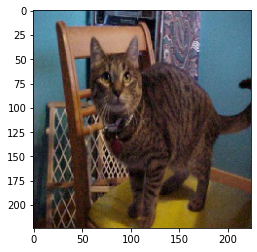

In [18]:
img, x = load_image("/content/drive/MyDrive/cats/cats_00001.jpg")
print("shape of x: ", x.shape)
print("data type: ", x.dtype)
plt.imshow(img)

In [19]:
# forward the image through the network
predictions = model.predict(x)

# print out the 
for _, pred, prob in decode_predictions(predictions)[0]:
    print("predicted %s with probability %0.3f" % (pred, prob))

49152/35363 [=========================================] - 0s 0us/step
predicted tiger_cat with probability 0.370
predicted tabby with probability 0.331
predicted Egyptian_cat with probability 0.164
predicted lynx with probability 0.018
predicted toilet_seat with probability 0.007


In [20]:
feat_extractor = Model(inputs=model.input, outputs=model.get_layer("fc2").output)
feat_extractor.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [21]:
images_path = '/content/drive/MyDrive/cats'
image_extensions = ['.jpg', '.png', '.jpeg']   # case-insensitive (upper/lower doesn't matter)
max_num_images = 10000

images = [os.path.join(dp, f) for dp, dn, filenames in os.walk(images_path) for f in filenames if os.path.splitext(f)[1].lower() in image_extensions]
if max_num_images < len(images):
    images = [images[i] for i in sorted(random.sample(xrange(len(images)), max_num_images))]

print("keeping %d images to analyze" % len(images))

keeping 1000 images to analyze


In [22]:
import time
tic = time.clock()


features = []
for i, image_path in enumerate(images):
    if i % 500 == 0:
        toc = time.clock()
        elap = toc-tic;
        print("analyzing image %d / %d. Time: %4.4f seconds." % (i, len(images),elap))
        tic = time.clock()
    img, x = load_image(image_path);
    feat = feat_extractor.predict(x)[0]
    features.append(feat)

print('finished extracting features for %d images' % len(images))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
  # This is added back by InteractiveShellApp.init_path()


analyzing image 0 / 1000. Time: 0.0004 seconds.
analyzing image 500 / 1000. Time: 486.8632 seconds.
finished extracting features for 1000 images


In [23]:
from sklearn.decomposition import PCA

features = np.array(features)
pca = PCA(n_components=300)
pca.fit(features)

PCA(copy=True, iterated_power='auto', n_components=300, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False)

In [24]:
pca_features = pca.transform(features)

In [30]:
import random
query_image_idx = int(len(images) * random.random())

In [31]:
from scipy.spatial import distance

similar_idx = [ distance.cosine(pca_features[query_image_idx], feat) for feat in pca_features ]

In [32]:
idx_closest = sorted(range(len(similar_idx)), key=lambda k: similar_idx[k])[1:6]

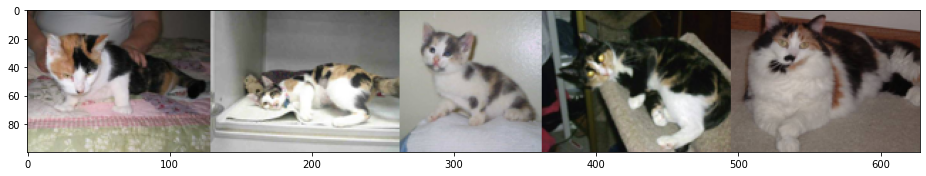

In [33]:
# load all the similarity results as thumbnails of height 100
thumbs = []
for idx in idx_closest:
    img = image.load_img(images[idx])
    img = img.resize((int(img.width * 100 / img.height), 100))
    thumbs.append(img)

# concatenate the images into a single image
concat_image = np.concatenate([np.asarray(t) for t in thumbs], axis=1)

# show the image
plt.figure(figsize = (16,12))
plt.imshow(concat_image)

In [34]:
def get_closest_images(query_image_idx, num_results=5):
    distances = [ distance.cosine(pca_features[query_image_idx], feat) for feat in pca_features ]
    idx_closest = sorted(range(len(distances)), key=lambda k: distances[k])[1:num_results+1]
    return idx_closest

def get_concatenated_images(indexes, thumb_height):
    thumbs = []
    for idx in indexes:
        img = image.load_img(images[idx])
        img = img.resize((int(img.width * thumb_height / img.height), thumb_height))
        thumbs.append(img)
    concat_image = np.concatenate([np.asarray(t) for t in thumbs], axis=1)
    return concat_image

Text(0.5, 1.0, 'result images')

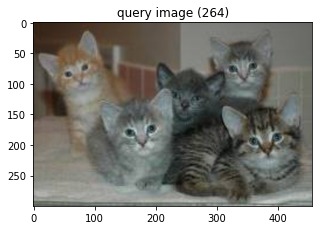

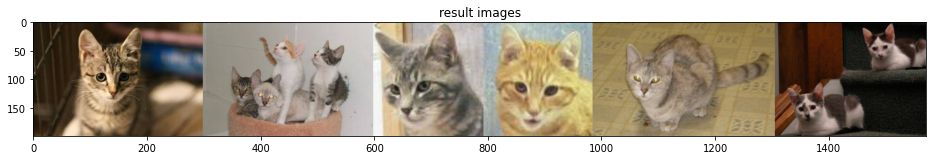

In [35]:
# do a query on a random image
query_image_idx = int(len(images) * random.random())
idx_closest = get_closest_images(query_image_idx)
query_image = get_concatenated_images([query_image_idx], 300)
results_image = get_concatenated_images(idx_closest, 200)

# display the query image
plt.figure(figsize = (5,5))
plt.imshow(query_image)
plt.title("query image (%d)" % query_image_idx)

# display the resulting images
plt.figure(figsize = (16,12))
plt.imshow(results_image)
plt.title("result images")

Text(0.5, 1.0, 'result images')

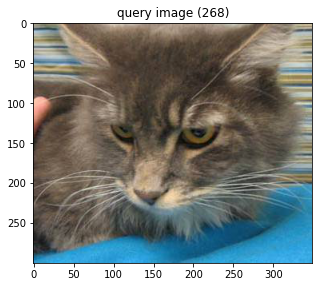

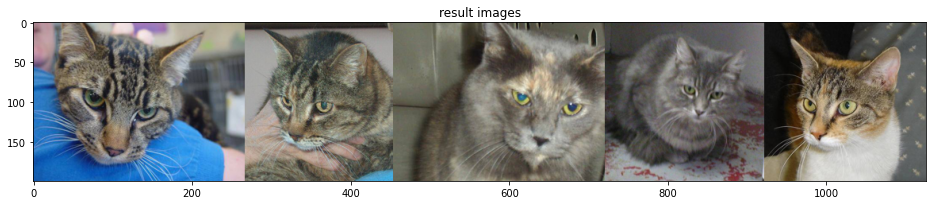

In [36]:
# do a query on a random image
query_image_idx = int(len(images) * random.random())
idx_closest = get_closest_images(query_image_idx)
query_image = get_concatenated_images([query_image_idx], 300)
results_image = get_concatenated_images(idx_closest, 200)

# display the query image
plt.figure(figsize = (5,5))
plt.imshow(query_image)
plt.title("query image (%d)" % query_image_idx)

# display the resulting images
plt.figure(figsize = (16,12))
plt.imshow(results_image)
plt.title("result images")
